# Import Libraries

In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
label_to_predict = 'Credit_Score'


# Using R, here are the names of each column after data processing:
categorical_columns = ['payday_loan', 'mortgage_loan', 'student_loan', 'not_specified',
 'home_equity_loan', 'credit.builder_loan', 'No_Data', 'personal_loan',
 'auto_loan', 'debt_consolidation_loan', 'EncodedSpent', 'EncodedValue_Payments',
 'Credit_Mix_Encoded', 'Occupation_Encoded', 'Encoded_Payment']

numerical_columns = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']



#the following list is ordered by FOCI
foci_columns = [ "Outstanding_Debt", "Interest_Rate", "Num_Credit_Card", 
"Num_of_Loan", "Credit_History_Age", "Annual_Income", "Amount_invested_monthly",
 "Total_EMI_per_month", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Changed_Credit_Limit",
 "Num_of_Delayed_Payment","Delay_from_due_date","Num_Credit_Inquiries", "Credit_Utilization_Ratio"]

 

In [3]:
# Importing the processed datasets
train_data = pd.read_csv('data/train_1_DEC.csv', index_col=0)
test_data = pd.read_csv('data/test_1_DEC.csv', index_col=0)

# Removing unnecessary columns
del train_data['Customer_ID']
del test_data['Customer_ID']


## Feature Engineering

In [4]:
# Perform dimension reduction on features based on the results of the FOCI algorithm
label_encoder = LabelEncoder()

X_tr1 = train_data[foci_columns]
y_tr1 = label_encoder.fit_transform(train_data[label_to_predict]).astype(int)

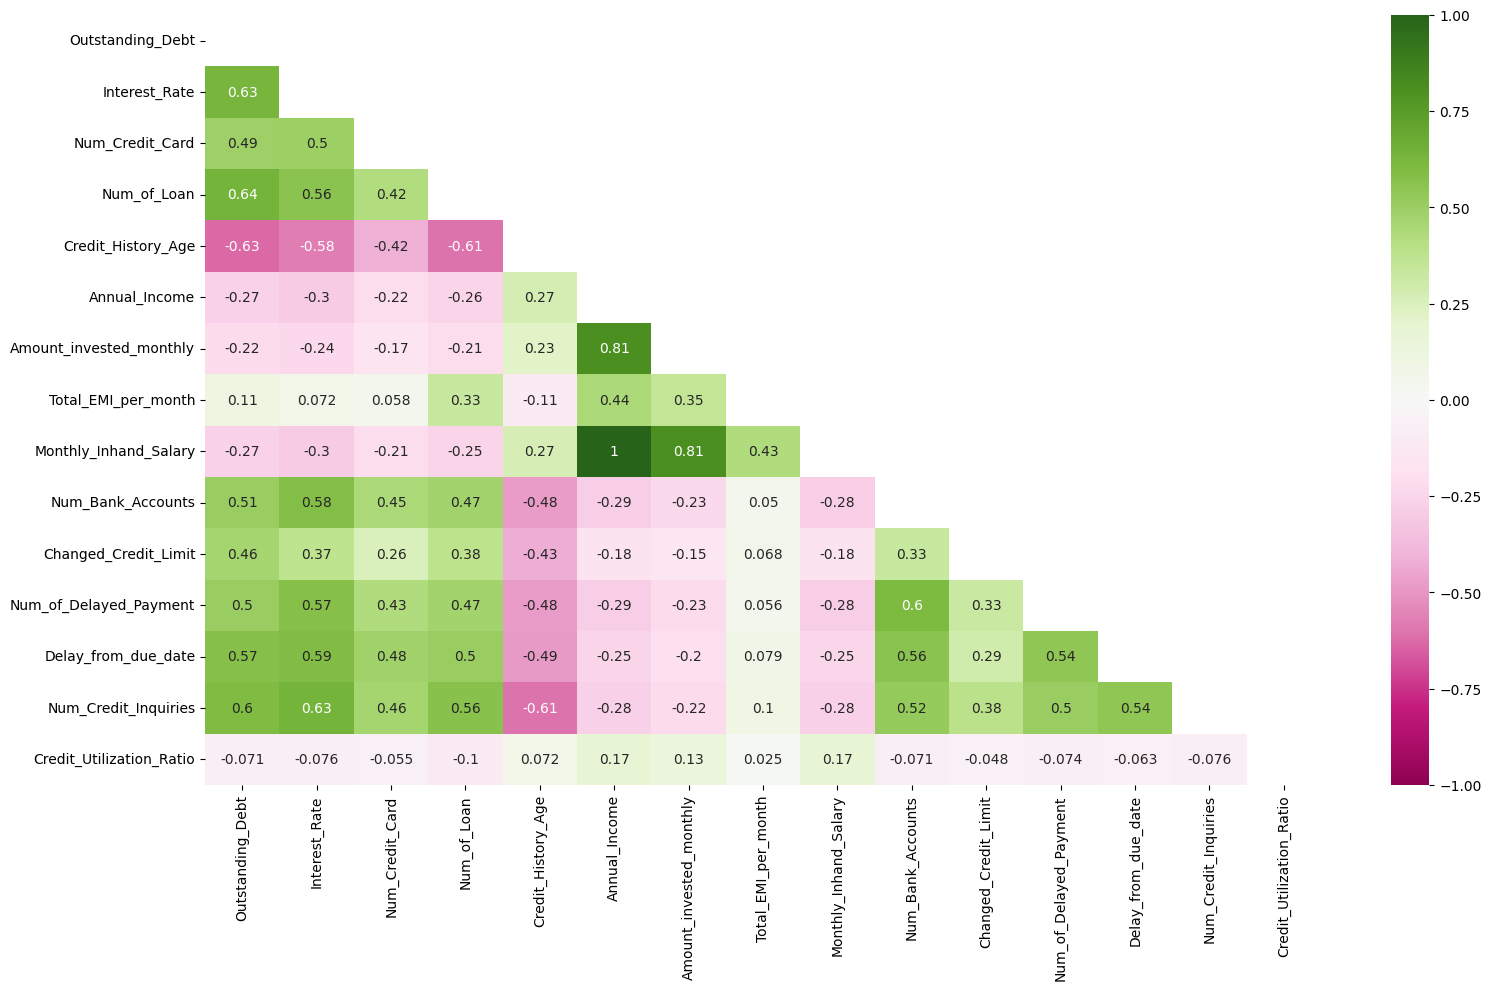

In [5]:
# Correlation between Numerical features
# Examining the correlations of our selected features using a heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(
    X_tr1.corr(), 
    mask=np.triu(np.ones_like(X_tr1.corr(), dtype=bool)), 
    annot=True, vmin=-1, vmax=1, cmap="PiYG"
);
#Conclusion

"Annual income" and "monthly_inhand_salary" essentially represent the same concept, 

with a correlation coefficient of 1. Additionally, both are strongly correlated with "amount_invested_monthly" with a correlation coefficient of 0.81.

 Therefore, in the feature selection process ,  remove these redundant features

In [6]:
#Try to create new features that combine old featureas
train_data['Debt_Income_Ratio'] = train_data['Outstanding_Debt'] / train_data['Annual_Income']
test_data['Debt_Income_Ratio'] = test_data['Outstanding_Debt'] / test_data['Annual_Income']

train_data['Net_Monthly_Income'] = train_data['Monthly_Inhand_Salary'] - train_data['Total_EMI_per_month']
test_data['Net_Monthly_Income'] = test_data['Monthly_Inhand_Salary'] - test_data['Total_EMI_per_month']

train_data['Financial_Products_Diversity'] = train_data['Num_Bank_Accounts'] + train_data['Num_Credit_Card']
test_data['Financial_Products_Diversity'] = test_data['Num_Bank_Accounts'] + test_data['Num_Credit_Card']

train_data['Investment_to_Income_Ratio'] = train_data['Amount_invested_monthly'] / train_data['Monthly_Inhand_Salary']
test_data['Investment_to_Income_Ratio'] = test_data['Amount_invested_monthly'] / test_data['Monthly_Inhand_Salary']

train_data['Avg_Delay_Per_Payment'] = train_data.apply(lambda x: x['Delay_from_due_date'] / x['Num_of_Delayed_Payment'] 
                                       if x['Num_of_Delayed_Payment'] > 0 else 0, axis=1)
test_data['Avg_Delay_Per_Payment'] = test_data.apply(lambda x: x['Delay_from_due_date'] / x['Num_of_Delayed_Payment'] 
                                       if x['Num_of_Delayed_Payment'] > 0 else 0, axis=1)
                                       
train_data['Credit_Change_Frequency'] = train_data['Changed_Credit_Limit'] + train_data['Num_Credit_Inquiries']
test_data['Credit_Change_Frequency'] = test_data['Changed_Credit_Limit'] + test_data['Num_Credit_Inquiries']

In [7]:
def assign_delay_freq(row):
  if row <= 7:
    return 0
  elif 7<row <= 12:
    return 1
  elif 12<row <= 20:
    return 2
  else:
    return 3

train_data['Num_of_Delayed_Payment'] = train_data['Num_of_Delayed_Payment'].apply(assign_delay_freq)
test_data['Num_of_Delayed_Payment'] = test_data['Num_of_Delayed_Payment'].apply(assign_delay_freq)

In [8]:
def assign_delay_group(row):
    if row <= 4:
        return 0
    elif 4 < row <= 15:
        return 1
    elif 15 < row <= 30:
        return 2
    else:
        return 3

train_data['Delay_from_due_date'] = train_data['Delay_from_due_date'].apply(assign_delay_group)
test_data['Delay_from_due_date'] = test_data['Delay_from_due_date'].apply(assign_delay_group)


## Statistical Test

Feature selection for categorical columns

In [9]:
from sklearn.feature_selection import f_classif,SelectKBest

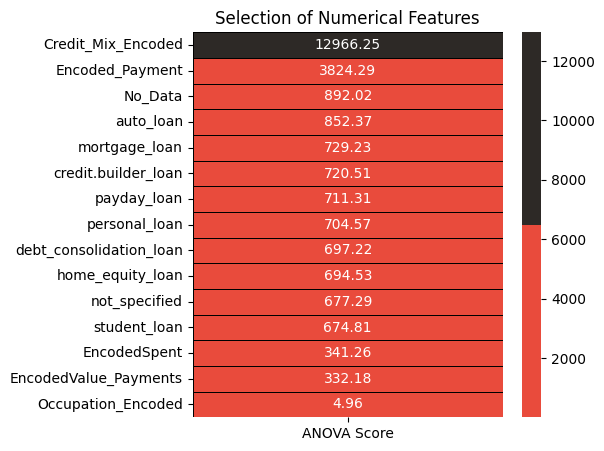

In [10]:
features = train_data[categorical_columns]  # Select the categorical columns
target = train_data[label_to_predict]  
colors = ['#E94B3C','#2D2926']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

We will therefore put credit-mix-encoded in our model

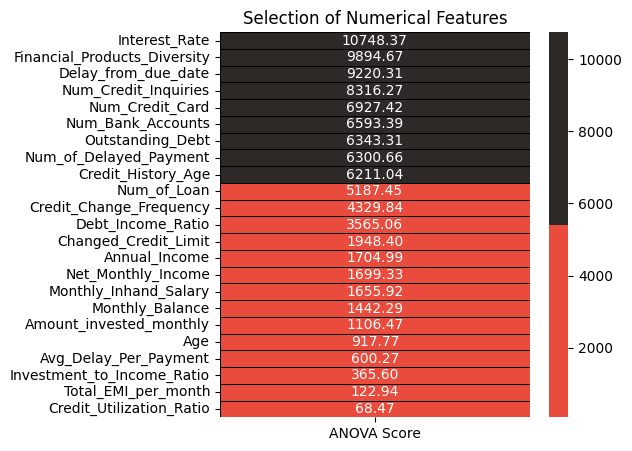

In [11]:
features = train_data.drop(columns=categorical_columns+[label_to_predict])

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [12]:
#We select the feature according to the ANOVA test score
# in the final feature selection, we removed two strongly correlated featuresSelected the top ten features in foci_columns (the best combination after multiple attempts), excluding 'Monthly_Inhand_Salary' and 'Amount_invested_monthly'
# Select features where ANOVA Score is greater than 3000
selected_features = [col for col in featureScores.index if featureScores.loc[col, 'ANOVA Score'] > 3000]

# Exclude the features that you do not want in the final selection
selected_features = [col for col in selected_features if col not in ['Monthly_Inhand_Salary', 'Amount_invested_monthly']]

if 'Credit_Mix_Encoded' not in selected_features:
    selected_features.append('Credit_Mix_Encoded')

# We found that the created new columns would actually decrease the accuracy of our model,
#Therefore we stick to foci selescted columns

selected_columns = [column for column in foci_columns[:10] if column not in ['Monthly_Inhand_Salary', 'Amount_invested_monthly']]
selected_columns.append('Credit_Mix_Encoded')



print(selected_columns)
print()
print(selected_features)

['Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Card', 'Num_of_Loan', 'Credit_History_Age', 'Annual_Income', 'Total_EMI_per_month', 'Num_Bank_Accounts', 'Credit_Mix_Encoded']

['Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Debt_Income_Ratio', 'Financial_Products_Diversity', 'Credit_Change_Frequency', 'Credit_Mix_Encoded']


We also tried normalization(log transformation) as well as 

SMOTE but did not increase the accuracy,therefore we did not applied those methods

In [13]:
'''# List of columns to plot
columns_to_plot = ['Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Card', 
                   'Num_of_Loan', 'Credit_History_Age', 'Annual_Income', 
                   'Total_EMI_per_month', 'Num_Bank_Accounts']

# Plotting the distribution of each column
for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    sns.histplot(X_tr2[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
    '''


"# List of columns to plot\ncolumns_to_plot = ['Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Card', \n                   'Num_of_Loan', 'Credit_History_Age', 'Annual_Income', \n                   'Total_EMI_per_month', 'Num_Bank_Accounts']\n\n# Plotting the distribution of each column\nfor column in columns_to_plot:\n    plt.figure(figsize=(10, 5))\n    sns.histplot(X_tr2[column], kde=True)\n    plt.title(f'Distribution of {column}')\n    plt.xlabel(column)\n    plt.ylabel('Frequency')\n    plt.show()\n    "

In [14]:
'''from scipy import stats
X_tr2['Annual_Income'] = X_tr2['Annual_Income'] + 0.000000001 - X_tr2['Annual_Income'].min()
X_tr2['Annual_Income'], fitted_lambda = stats.boxcox(X_tr2['Annual_Income'])

# Assuming X_tr2 is your DataFrame and has been loaded appropriately
X_tr2['Total_EMI_per_month'] = X_tr2['Total_EMI_per_month'] + 0.000000001 - X_tr2['Total_EMI_per_month'].min()
X_tr2['Total_EMI_per_month'], fitted_lambda = stats.boxcox(X_tr2['Total_EMI_per_month'])

# Make sure there are no zero or negative values for 'Outstanding_Debt'
X_tr2['Outstanding_Debt'] = X_tr2['Outstanding_Debt'] + 0.000000001 - X_tr2['Outstanding_Debt'].min()
X_tr2['Outstanding_Debt'], fitted_lambda_debt = stats.boxcox(X_tr2['Outstanding_Debt'])

# Check for any NaN or inf values after transformation for 'Annual_Income'
print("Annual_Income - Number of NaN values:", X_tr2['Annual_Income'].isna().sum())
print("Annual_Income - Number of inf values:", np.isinf(X_tr2['Annual_Income']).sum())

# Check for any NaN or inf values after transformation for 'Outstanding_Debt'
print("Outstanding_Debt - Number of NaN values:", X_tr2['Outstanding_Debt'].isna().sum())
print("Outstanding_Debt - Number of inf values:", np.isinf(X_tr2['Outstanding_Debt']).sum())

# Check for any NaN or inf values after transformation for 'Total_EMI_per_month'
print("Total_EMI_per_month - Number of NaN values:", X_tr2['Total_EMI_per_month'].isna().sum())
print("AnnualTotal_EMI_per_month_Income - Number of inf values:", np.isinf(X_tr2['Total_EMI_per_month']).sum())
'''

'from scipy import stats\nX_tr2[\'Annual_Income\'] = X_tr2[\'Annual_Income\'] + 0.000000001 - X_tr2[\'Annual_Income\'].min()\nX_tr2[\'Annual_Income\'], fitted_lambda = stats.boxcox(X_tr2[\'Annual_Income\'])\n\n# Assuming X_tr2 is your DataFrame and has been loaded appropriately\nX_tr2[\'Total_EMI_per_month\'] = X_tr2[\'Total_EMI_per_month\'] + 0.000000001 - X_tr2[\'Total_EMI_per_month\'].min()\nX_tr2[\'Total_EMI_per_month\'], fitted_lambda = stats.boxcox(X_tr2[\'Total_EMI_per_month\'])\n\n# Make sure there are no zero or negative values for \'Outstanding_Debt\'\nX_tr2[\'Outstanding_Debt\'] = X_tr2[\'Outstanding_Debt\'] + 0.000000001 - X_tr2[\'Outstanding_Debt\'].min()\nX_tr2[\'Outstanding_Debt\'], fitted_lambda_debt = stats.boxcox(X_tr2[\'Outstanding_Debt\'])\n\n# Check for any NaN or inf values after transformation for \'Annual_Income\'\nprint("Annual_Income - Number of NaN values:", X_tr2[\'Annual_Income\'].isna().sum())\nprint("Annual_Income - Number of inf values:", np.isinf(X_tr2[

In [15]:

X_tr2 = train_data[selected_columns]
print(X_tr2.shape)
print(y_tr1.shape)

(70000, 9)
(70000,)


# Model Tuning and Comparison

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Splitting the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_tr2, y_tr1, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((56000, 9), (56000,), (14000, 9), (14000,))

We attempted to use SMOTE on the training set to achieve a uniform distribution, aiming to reduce bias during model training, and also applied normalization to the data. However, we found that this did not improve the final prediction accuracy, hence we removed this step.


scaler = MinMaxScaler()

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
#The data set shows unbalance distribution. This may cause a biased estimate. 
#So we will use SMOTE, an oversampling process that allows synthetic data to be generated.
smote_train_X, smote_train_Y = sm.fit_resample(X_train, y_train)

# Model Comparison

In [17]:
# Here we define our support function for comparing the accuracy of our models

In [18]:
from sklearn.metrics import confusion_matrix, classification_report 

# Defined a function to evaluate model performance
def eval(model, X_train, X_val, y_train=y_train, y_val=y_val):
    print('TEST')
    y_val_pred = model.predict(X_val)
    print(confusion_matrix(y_val, y_val_pred))
    # Print the confusion matrix for the validation set, which shows the relationship between actual labels and predicted labels.
    print(classification_report(y_val, y_val_pred))
    # Print the classification report for the validation set, including key classification metrics such as accuracy, recall, F1 score, etc.
    print("-------------------------------------------------------")
    print('TRAIN')
    y_train_pred = model.predict(X_train)
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import make_scorer

# Created a scoring dictionary 'scoring' for measuring performance in multi-class classification
scoring = {
    'precision': make_scorer(precision_score, average=None, labels=[1]), 
    # Precision scorer, calculates precision only for the class with label 1
    'recall'   : make_scorer(recall_score, average=None, labels=[1]),   
    # Recall scorer, similarly targets only the class with label 1
    'f1'       : make_scorer(f1_score, average=None, labels=[1]),
    # F1 score scorer, specific to the class with label 1
    'accuracy' : make_scorer(accuracy_score),
    # Accuracy scorer, computes overall accuracy for all classes

} 
# Identify people with low credit scores
# recall_1    = make_scorer(recall_score, average = None, labels=[1])
scoring['recall'] 
# log_loss_neg = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

make_scorer(recall_score, average=None, labels=[1])

In [20]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 0.Xgboost

In [21]:

xgb = XGBClassifier(n_jobs=-1, n_estimators=100,   
    random_state=42,
)

In [22]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [81]:
print("Xgboost MODEL")
eval(xgb, X_train, X_val)

Xgboost MODEL
TEST
[[1880   18  648]
 [ 181 3107  824]
 [ 735  919 5688]]
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      2546
           1       0.77      0.76      0.76      4112
           2       0.79      0.77      0.78      7342

    accuracy                           0.76     14000
   macro avg       0.75      0.76      0.75     14000
weighted avg       0.76      0.76      0.76     14000

-------------------------------------------------------
TRAIN
[[ 8059    62  1854]
 [  552 13038  2697]
 [ 2136  3188 24414]]
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      9975
           1       0.80      0.80      0.80     16287
           2       0.84      0.82      0.83     29738

    accuracy                           0.81     56000
   macro avg       0.80      0.81      0.80     56000
weighted avg       0.81      0.81      0.81     56000



With Best Parameters (GridsearchCV)

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid_xgb = {
    'n_estimators' : [100],
    'learning_rate': np.linspace(0.01, 0.3, 2).round(3),
    'max_depth'    : [5, 6],   
#     'reg_alpha'    : [0, 0.5, 1],  
#     'reg_lambda'   : [0, 0.5, 1], 
}
grid_model_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring = scoring['recall'], # 'neg_log_loss'      
    error_score='raise',     
    n_jobs = -1,
#     refit=True,
    cv=5,
)

In [59]:
grid_model_xgb.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.3 ]),
                         'max_depth': [5, 6], 'n_estimators': [100]},
             scoring=make_scorer(recall_score, average=None, labels=[1]))

In [60]:
# Get the best hyperparameters
best_params_xgb = grid_model_xgb.best_params_

best_params_xgb, grid_model_xgb.best_score_

'''({'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100},
 0.7279427810299693)'''

({'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100},
 0.7279427810299693)

In [62]:
print("GRID XGB MODEL BALANCED")
eval(grid_model_xgb, X_train, X_val)

GRID XGB MODEL BALANCED
TEST
[[1561   18  967]
 [ 102 3073  937]
 [ 556  894 5892]]
              precision    recall  f1-score   support

           0       0.70      0.61      0.66      2546
           1       0.77      0.75      0.76      4112
           2       0.76      0.80      0.78      7342

    accuracy                           0.75     14000
   macro avg       0.74      0.72      0.73     14000
weighted avg       0.75      0.75      0.75     14000

-------------------------------------------------------
TRAIN
[[ 6829    71  3075]
 [  380 12803  3104]
 [ 1530  3214 24994]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73      9975
           1       0.80      0.79      0.79     16287
           2       0.80      0.84      0.82     29738

    accuracy                           0.80     56000
   macro avg       0.79      0.77      0.78     56000
weighted avg       0.80      0.80      0.80     56000



## 1.Decision Tree

In [23]:
decision_tree = DecisionTreeClassifier(random_state=42)

In [24]:
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [25]:
print("decision tree MODEL")
eval(decision_tree, X_train, X_val)

decision tree MODEL
TEST
[[1951    8  587]
 [  13 3262  837]
 [ 553  826 5963]]
              precision    recall  f1-score   support

           0       0.78      0.77      0.77      2546
           1       0.80      0.79      0.79      4112
           2       0.81      0.81      0.81      7342

    accuracy                           0.80     14000
   macro avg       0.79      0.79      0.79     14000
weighted avg       0.80      0.80      0.80     14000

-------------------------------------------------------
TRAIN
[[ 9975     0     0]
 [    0 16286     1]
 [   11    27 29700]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9975
           1       1.00      1.00      1.00     16287
           2       1.00      1.00      1.00     29738

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000



With best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the grid search model
grid_model_tree = GridSearchCV(estimator=decision_tree, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_model_tree.fit(X_train, y_train)

In [65]:
# Get the best hyperparameters
best_params_tree = grid_model_tree.best_params_

best_params_tree, grid_model_xgb.best_score_

'''{'criterion': 'entropy',
  'max_depth': 40,
  'min_samples_leaf': 1,
  'min_samples_split': 2}'''

({'criterion': 'entropy',
  'max_depth': 40,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 0.7279427810299693)

In [66]:
print("GRID Decision tree MODEL BALANCED")
eval(grid_model_tree, X_train, X_val)

GRID Decision tree MODEL BALANCED
TEST
[[1941    8  597]
 [   6 3291  815]
 [ 565  827 5950]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      2546
           1       0.80      0.80      0.80      4112
           2       0.81      0.81      0.81      7342

    accuracy                           0.80     14000
   macro avg       0.79      0.79      0.79     14000
weighted avg       0.80      0.80      0.80     14000

-------------------------------------------------------
TRAIN
[[ 9975     0     0]
 [    0 16286     1]
 [   22    43 29673]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9975
           1       1.00      1.00      1.00     16287
           2       1.00      1.00      1.00     29738

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000



## 2.Random Forest

In [26]:
randomForest = RandomForestClassifier(random_state=42,n_estimators=100, n_jobs=-1)

In [27]:
randomForest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [28]:
print("random forest MODEL")
eval(randomForest, X_train, X_val)

random forest MODEL
TEST
[[1978    0  568]
 [   0 3326  786]
 [ 531  800 6011]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2546
           1       0.81      0.81      0.81      4112
           2       0.82      0.82      0.82      7342

    accuracy                           0.81     14000
   macro avg       0.80      0.80      0.80     14000
weighted avg       0.81      0.81      0.81     14000

-------------------------------------------------------
TRAIN
[[ 9971     0     4]
 [    0 16277    10]
 [   14    22 29702]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9975
           1       1.00      1.00      1.00     16287
           2       1.00      1.00      1.00     29738

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000



With best parameters

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}
grid_search_rf = GridSearchCV(estimator=randomForest, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

In [69]:
# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_

best_params_rf, grid_search_rf.best_score_
'''{'criterion': 'gini',
  'max_depth': 30,
  'min_samples_leaf': 1,
  'min_samples_split': 2}'''

({'criterion': 'gini',
  'max_depth': 30,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 0.7941249730825072)

## 3.Bagging

In [39]:
bagging = BaggingClassifier(n_jobs=-1, 
            n_estimators=50,
              
            random_state=42)

In [40]:
bagging.fit(X_train, y_train)

BaggingClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [41]:
print("bagging MODEL")
eval(bagging, X_train, X_val)

bagging MODEL
TEST
[[1984    0  562]
 [   3 3348  761]
 [ 532  809 6001]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      2546
           1       0.81      0.81      0.81      4112
           2       0.82      0.82      0.82      7342

    accuracy                           0.81     14000
   macro avg       0.80      0.80      0.80     14000
weighted avg       0.81      0.81      0.81     14000

-------------------------------------------------------
TRAIN
[[ 9957     0    18]
 [    0 16273    14]
 [   28    56 29654]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9975
           1       1.00      1.00      1.00     16287
           2       1.00      1.00      1.00     29738

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000



With best parameters

In [ ]:
param_grid_bagging = {
    'n_estimators': [10, 50, 100],  # Number of base estimators in the ensemble
    'max_samples': [0.5, 1.0],  # Maximum number of samples to draw to train each base estimator
    'max_features': [0.5, 1.0],  # Maximum number of features to draw to train each base estimator
    'bootstrap': [True, False],  # Whether samples are drawn with or without replacement
    'bootstrap_features': [True, False]  # Whether features are drawn with or without replacement
}
grid_search_bagging = GridSearchCV(estimator=bagging, param_grid=param_grid_bagging, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_bagging.fit(X_train, y_train)

In [76]:
# Get the best hyperparameters
best_params_bagging = grid_search_bagging.best_params_

best_params_bagging
'''{'bootstrap': False,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 0.5,
 'n_estimators': 100}'''

{'bootstrap': False,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 0.5,
 'n_estimators': 100}

## 4.Extra tree

In [29]:
extraTrees = ExtraTreesClassifier(max_depth=30, n_jobs=-1,random_state=42)

In [30]:
extraTrees.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=30, n_jobs=-1, random_state=42)

In [59]:
depth = extraTrees.max_depth
min_samples_leaf = extraTrees.min_samples_leaf
depth,min_samples_leaf

(30, 1)

In [31]:
print("extraTrees MODEL")
eval(extraTrees, X_train, X_val)

extraTrees MODEL
TEST
[[1996    0  550]
 [   1 3322  789]
 [ 536  792 6014]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      2546
           1       0.81      0.81      0.81      4112
           2       0.82      0.82      0.82      7342

    accuracy                           0.81     14000
   macro avg       0.80      0.80      0.80     14000
weighted avg       0.81      0.81      0.81     14000

-------------------------------------------------------
TRAIN
[[ 9974     0     1]
 [    0 16283     4]
 [   10    24 29704]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9975
           1       1.00      1.00      1.00     16287
           2       1.00      1.00      1.00     29738

    accuracy                           1.00     56000
   macro avg       1.00      1.00      1.00     56000
weighted avg       1.00      1.00      1.00     56000



With best parameters

In [ ]:
param_grid_extratree = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [20, 30, 40, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Instantiate the grid search model
grid_search_extratree = GridSearchCV(estimator=extraTrees, param_grid=param_grid_extratree, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_extratree.fit(X_train, y_train)

In [81]:
# Get the best hyperparameters
best_params_extratrees = grid_search_extratree.best_params_

best_params_extratrees
'''
{'bootstrap': False,
'bootstrap_features': False,
 'max_features': 1.0, 
 'max_samples': 0.5, 
 'n_estimators': 100}
 '''

"{'bootstrap': False,\n 'bootstrap_features': False,\n 'max_features': 1.0,\n 'max_samples': 0.5,\n 'n_estimators': 100}"

## 5.HistGradientBoosting

In [32]:
histGradientBoosting = HistGradientBoostingClassifier(max_iter=200,random_state=42)

In [33]:
histGradientBoosting.fit(X_train,y_train)

HistGradientBoostingClassifier(max_iter=200, random_state=42)

In [34]:
print("histGradientBoosting")
eval(histGradientBoosting, X_train, X_val)

histGradientBoosting
TEST
[[1889   12  645]
 [ 138 3172  802]
 [ 701  928 5713]]
              precision    recall  f1-score   support

           0       0.69      0.74      0.72      2546
           1       0.77      0.77      0.77      4112
           2       0.80      0.78      0.79      7342

    accuracy                           0.77     14000
   macro avg       0.75      0.76      0.76     14000
weighted avg       0.77      0.77      0.77     14000

-------------------------------------------------------
TRAIN
[[ 8203    43  1729]
 [  405 13366  2516]
 [ 2041  3212 24485]]
              precision    recall  f1-score   support

           0       0.77      0.82      0.80      9975
           1       0.80      0.82      0.81     16287
           2       0.85      0.82      0.84     29738

    accuracy                           0.82     56000
   macro avg       0.81      0.82      0.82     56000
weighted avg       0.82      0.82      0.82     56000



With best parameters

In [ ]:
param_grid_hgb = {
    'max_iter': [100, 200, 300],  # Maximum number of iterations of the algorithm
    'learning_rate': [0.01, 0.1, 0.2],  # Boosting learning rate
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_leaf': [20, 40, 60],  # Minimum number of samples per leaf
    'l2_regularization': [0, 0.1, 1]  # L2 regularization term on weights
}
# Instantiate the grid search model
grid_search_hgb = GridSearchCV(estimator=histGradientBoosting, param_grid=param_grid_hgb, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
# Fit the grid search to the data
grid_search_hgb.fit(X_train, y_train)

In [86]:
# Get the best hyperparameters
best_params_hgb = grid_search_hgb.best_params_

best_params_hgb
'''
{'l2_regularization': 0,
 'learning_rate': 0.2,
 'max_depth': 10,
 'max_iter': 300,
 'min_samples_leaf': 20}
 '''

{'l2_regularization': 0,
 'learning_rate': 0.2,
 'max_depth': 10,
 'max_iter': 300,
 'min_samples_leaf': 20}

Some models failed,ex:

In [ ]:
'''votingC=VotingClassifier(estimators=[("KNN",KNeighborsClassifier(n_neighbors=4)),
                                    ("RF",RandomForestClassifier(random_state=0)),
                                    ("BC",BaggingClassifier(random_state=0))],
                        voting="soft", n_jobs=-1)

votingC.fit(X_train2,smote_train_Y)
print(accuracy_score(votingC.predict(X_val2),y_val))
'''

# Comparison AUC

---------------XGB---------------


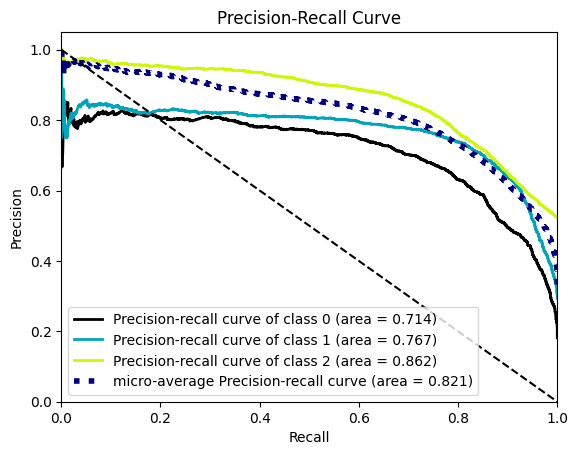

In [47]:
import scikitplot as skplt

y_val_proba = xgb.predict_proba(X_val)
skplt.metrics.plot_precision_recall(y_val, y_val_proba);
# skplt.metrics.plot_roc(y_test, y_prob_test)
plt.plot([0, 1],[1, 0], 'k--')
print('---------------XGB---------------')
plt.show()

---------------decision_tree---------------


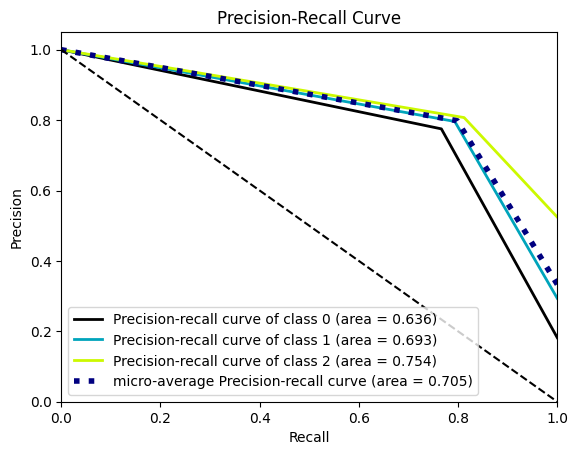

In [48]:
y_val_proba = decision_tree.predict_proba(X_val)
skplt.metrics.plot_precision_recall(y_val, y_val_proba);
# skplt.metrics.plot_roc(y_test, y_prob_test)
plt.plot([0, 1],[1, 0], 'k--')
print('---------------decision_tree---------------')
plt.show()

---------------Random Forest---------------


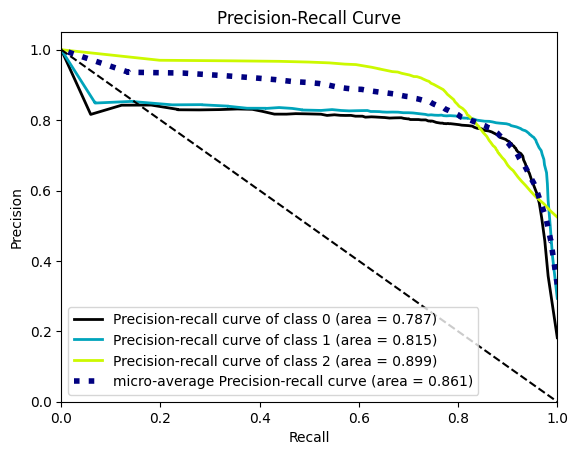

In [49]:
y_val_proba = randomForest.predict_proba(X_val)
skplt.metrics.plot_precision_recall(y_val, y_val_proba);
# skplt.metrics.plot_roc(y_test, y_prob_test)
plt.plot([0, 1],[1, 0], 'k--')
print('---------------Random Forest---------------')
plt.show()

---------------Bagging---------------


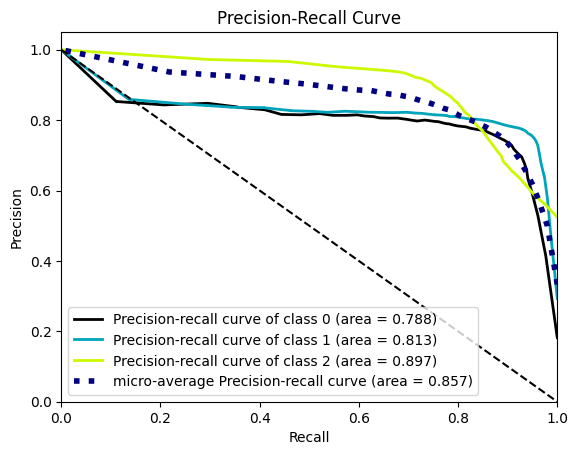

In [50]:
y_val_proba = bagging.predict_proba(X_val)
skplt.metrics.plot_precision_recall(y_val, y_val_proba);
# skplt.metrics.plot_roc(y_test, y_prob_test)
plt.plot([0, 1],[1, 0], 'k--')
print('---------------Bagging---------------')
plt.show()

---------------extraTrees---------------


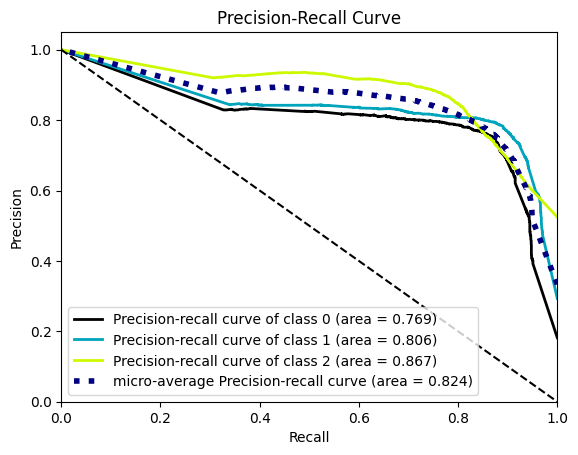

In [51]:
y_val_proba = extraTrees.predict_proba(X_val)
skplt.metrics.plot_precision_recall(y_val, y_val_proba);
# skplt.metrics.plot_roc(y_test, y_prob_test)
plt.plot([0, 1],[1, 0], 'k--')
print('---------------extraTrees---------------')
plt.show()

---------------histGradientBoosting---------------


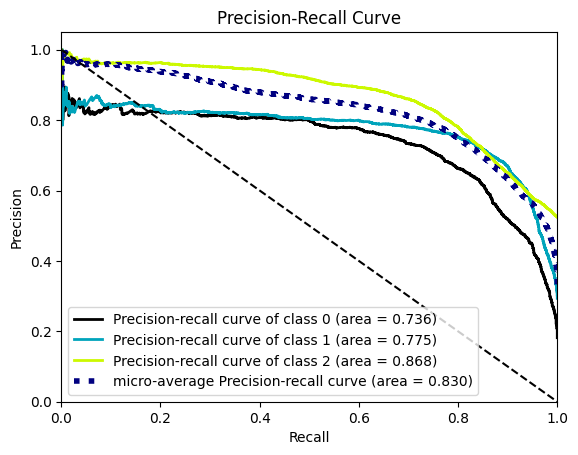

In [52]:
y_val_proba = histGradientBoosting.predict_proba(X_val)
skplt.metrics.plot_precision_recall(y_val, y_val_proba);
# skplt.metrics.plot_roc(y_test, y_prob_test)
plt.plot([0, 1],[1, 0], 'k--')
print('---------------histGradientBoosting---------------')
plt.show()

## Final Model

In [34]:
# Initialize different base classifiers
# We combined multiple weak classifiers to form a final ensemble model
# model one is the one that we had the best outcome
#update each base estimator with the best parameters 

# this is the one that we had the best outcome
final_model = StackingClassifier([
('bagging', bagging),
('extraTress', extraTrees),
('randomforest', randomForest),
('histGradientBoosting', histGradientBoosting),
('XGB', xgb)],
                            final_estimator=SVC(),
                            n_jobs=-1)




In [60]:
final_model.fit(X_tr2,y_tr1)

StackingClassifier(estimators=[('bagging',
                                BaggingClassifier(n_estimators=50, n_jobs=-1,
                                                  random_state=42)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=30, n_jobs=-1,
                                                     random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier(max_iter=200,
                                                               random_state=42)),
                               ('XGB',
                                XGBClassif...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=SVC(), n_jobs=-1)

# Generate Submission 

In [61]:
X_test = test_data[selected_columns]


In [62]:
def generate_submission():
    list_of_predictions = final_model.predict(X_test)
    preds = label_encoder.inverse_transform(list_of_predictions)
    df = pd.DataFrame({'Credit_Score': preds}, index=X_test.index)
    df.to_csv('sandbox_submission.csv')
    print(df['Credit_Score'].value_counts())

In [63]:
generate_submission()

Credit_Score
Standard    13875
Poor        10096
Good         6029
Name: count, dtype: int64
